<h1>Breaking Acceleration Exploration</h1>

In [21]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime
import cftime
from scipy import signal
%matplotlib widget


Text(0, 0.5, 'Acceleration [m/s^2')

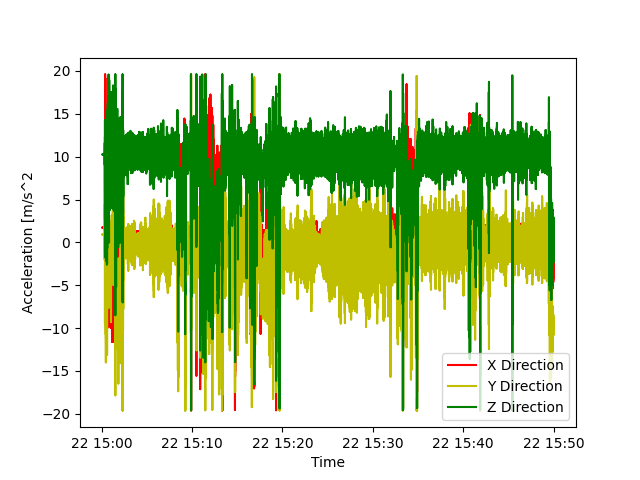

In [20]:
# Get Data set from mission 52 due to better notes on when in breaking 
mission_nc_path = '../microSWIFT_data/mission_52/mission_52.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Get list of microSWIFTs during this deployment
microSWIFTs_on_mission = list(mission_dataset.groups.keys())
num_micros = len(microSWIFTs_on_mission)

# Get actual datetime objects from netcdf time
accel_time_40 = cftime.num2pydate(mission_dataset['microSWIFT_40']['IMU']['time'], units=mission_dataset['microSWIFT_40']['IMU']['time'].units, calendar=mission_dataset['microSWIFT_40']['IMU']['time'].calendar)

# Plot the Accelerations in all three directions for each micro
fig_micro_1, ax = plt.subplots()
ax.plot(accel_time_40, mission_dataset['microSWIFT_40']['IMU']['accel_x'], color='r', label='X Direction')
ax.plot(accel_time_40, mission_dataset['microSWIFT_40']['IMU']['accel_y'], color='y', label='Y Direction')
ax.plot(accel_time_40, mission_dataset['microSWIFT_40']['IMU']['accel_z'], color='g', label='Z Direction')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration [m/s^2')



In [24]:
# Make Spectorgram of accelerations 
imu_sampling_freq = 12 # Units are Hz
f_accel_x_40, t_accel_x_40, Sxx_accel_x_40 = signal.spectrogram(mission_dataset['microSWIFT_40']['IMU']['accel_x'], fs=imu_sampling_freq)

# Plot Acceleration Spectrograms
fig_accel_x_spec, ax = plt.subplots()
ax.pcolor(t_accel_x_40, f_accel_x_40, Sxx_accel_x_40)

